# Face recognition

Face recognition concernes the identifing or verifying a person's identity from a visual input like an image or a video frame. It can be formulated as a classification problem, where the inputs are the images and the outputs are the identities or the names of the people.
This notebook analyses three different techniques for feature extraction in the context of face recognition:
    1. PCA (Principal Components Analysis)
    2. LDA (Linear Discirminant Analysis)
    3. LBP (Local Binary Patterns)
using three different datasets:
    1. AT&T Faces dataset
    2. Labeled faces of the wild
    
  

In [2]:
# local packages
from localmodules.datasets import load_faces
from localmodules.distance import L2_distance
from localmodules.local_binary_patterns import LBP

# sklearn packages
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, auc, precision_recall_curve, average_precision_score

import numpy as np
import cv2
import operator

import matplotlib.pyplot as plt


In [3]:
def get_faces(facesDB):
    if facesDB == "ATT":
        faces = load_faces("ATT", dataset = None, min_faces=10, max_targets=MAX_PERSONS)
    elif facesDB == "LFW": 
        faces = load_faces("LFW", dataset = None, min_faces=10, max_targets=MAX_PERSONS)
   
    return faces

### Definition of necessary methods for the flow of the system

In [6]:
def perform_method(DESC, faces):
    # select the feature embedding mehtod (PCA, LDA, LBP)
    # returns the vector-coded embedding of the images
    X = StandardScaler().fit_transform(faces.data) # standardization
    y = faces.target
    n_samples, h, w = faces.images.shape  
    n_features = faces.data.shape[1]
    if DESC == "PCA":
        # Compute a PCA (eigenfaces) on the face dataset
        pca_components = min(NUM_COMPONENTS, min(n_samples, n_features))
        print("Number of components {n}".format(n=pca_components))
        pca = PCA(n_components=pca_components, svd_solver='randomized', whiten=True)
        desc = pca.fit(X)
        print('Explained variance {}'.format(desc.explained_variance_ratio_))
        X_pca = desc.transform(X)  # Apply dimensionality reduction to X
        embedded = X_pca

    elif DESC == "LDA":
        lda_components = min(NUM_COMPONENTS, min(n_samples, n_features))
        print("Number of components {n}".format(n=lda_components))
        desc = LinearDiscriminantAnalysis(n_components=lda_components).fit(X, y)
        X_lda = desc.fit_transform(X, y)
        embedded = X_lda

    elif DESC == "LBP":
        desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
        embedded = desc.describe_list(faces.images)
        
    return embedded

In [7]:
def calculate_distances(DESC, embedded, faces):
    distances = [] # distance between pairs
    identical = [] # 1 if same identity, 0 otherwise
    n_samples, h, w = faces.images.shape  
    targets = faces.target

    I = np.zeros((n_samples, n_samples)) 

    for i in range(n_samples-1):
        for j in range(1, n_samples):
            if DESC == "LBP":
                # Kullback-Leibler Divergence for normalized histograms
                # distances.append(KLD(embedded[i], embedded[j]))
                # Better even: Chi-square distance
                distances.append(CHI2(embedded[i], embedded[j]))
            else:
                # Euclidean norm as distance
                distances.append(L2_distance(embedded[i], embedded[j]))
            if targets[i] == targets[j]:
                identical.append(1)
                I[i,j] = I[j,i] = 1
            else:
                identical.append(0)

    distances = np.array(distances)
    # convert to normalized [0,1] score (the higher the better)
    scores = (distances.max() - distances)/distances.max()
    identical = np.array(identical)
    return I, scores, identical

In [8]:
def generate_genuine_impostor_pair(I, embedded, faces):
    genuine = np.asarray(np.where(I == 1)).T
    genuine_pair_id = np.random.randint(genuine.shape[0])

    impostor = np.asarray(np.where(I == 0)).T
    impostor_pair_id = np.random.randint(impostor.shape[0])

    show_pair(faces, embedded, genuine[genuine_pair_id][0], genuine[genuine_pair_id][1])
    show_pair(faces, embedded, impostor[impostor_pair_id][0], impostor[impostor_pair_id][1])

In [9]:
def get_true_pred_labels(all_scores, identical, dist_threshold):
    '''
    If the score i.e. the distance between two pairs is greater or equal
    to some predefined threshold, then we predict that the pair is genuine,
    otherwise it is impostor.
    Higher threshold means less flexible system, meaning that less pairs will
    be labeled as genuine. This usually makes the system highly secure.
    '''
    pred_y = []
    true_y = identical  # ground truth
    for i in range(0, len(all_scores)):        
        if all_scores[i] >= dist_threshold:  
            pred_y.append(1) 
        else: 
            pred_y.append(0)
    
    return true_y, pred_y

In [10]:
def get_geuine_impostor_scores(all_scores, identical):
    '''
    Returns two arrays with the geuine and impostor scores. 
    The genuine match scores are obtained by matching feature sets 
    of the same class (same person) and the impostor match scores are obtained 
    by matching feature sets of different classes (different persons)
    '''
    genuine_scores = []
    impostor_scores = []
    for i in range(0, len(all_scores)):        
        if identical[i] == 1: 
            genuine_scores.append(all_scores[i])
        else: 
            impostor_scores.append(all_scores[i])
    
    return genuine_scores, impostor_scores

In [12]:
def get_acc_f1_for_threshold(all_scores, identical, dist_threshold):
    '''
    Computes predicted labels for the given match scores / distances, to some
    threshold, and then computes the accuracy and f1 score
    '''
    true_y, pred_y = get_true_pred_labels(all_scores, identical, dist_threshold)
    acc = accuracy_score(true_y, pred_y)
    f1 = f1_score(true_y, pred_y)
    print('Accuracy with threshold = {}, is = {}'.format(round(dist_threshold, 2), round(acc,4)))
    print('F1 score with threshold = {}, is = {}'.format(round(dist_threshold, 2), round(f1, 4)))
    
    return acc, f1


In [13]:
def get_accuracy_f1_scores(all_scores, identical, thresholds):
    '''
    Accumulates all accuracy and f1 scores for given thresholds
    and finds the optimal threshold (the one with highest both accuracy and f1)
    '''
    accuracy_scores = []
    f1_scores = []
    optimal_threshold = 0
    best_acc = 0
    best_f1 = 0
    for dist_threshold in thresholds:
        acc, f1 = get_acc_f1_for_threshold(all_scores, identical, dist_threshold)
        if best_acc < acc and best_f1 < f1:
            optimal_threshold = dist_threshold
            best_acc = acc
            best_f1 = f1
        accuracy_scores.append(acc)
        f1_scores.append(f1)
        
    print('Optimal threshold = {}'.format(optimal_threshold))
    return accuracy_scores, f1_scores, optimal_threshold

In [15]:
def get_tp_fp_rates(all_scores, identical, thresholds): 
    '''
    Calculates the true positive and false positive rates, from the confusion matrix,
    according to some thresholded matching scores
    '''
    true_pos_rates = []
    false_pos_rates = []
    for dist_threshold in thresholds:
        true_y, pred_y = get_true_pred_labels(all_scores, identical, dist_threshold)
        tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()
        true_pos_rate, false_pos_rate = calculate_ratios(tp, fp, fn, tn)
        true_pos_rates.append(true_pos_rate)
        false_pos_rates.append(false_pos_rate)
        
    return true_pos_rates, false_pos_rates
    

In [16]:
def get_equal_error_rate(tpr, fpr):
    frr = 1 - np.asarray(tpr)
    min_diff = 1
    i_min = 0
    j_min = 0
    for i in range(0, len(frr)):
        for j in range(0, len(fpr)):
            diff = np.abs(frr[i] - fpr[j])
            if diff < min_diff and diff < 0.2:
                min_diff = diff
                i_min = i
                j_min = j
    
    return np.min([frr[i_min], fpr[j_min]])

In [17]:
def perform_all_steps(DESC, faces, embedded):
    print('--- Choosed technique: {}'.format(DESC))
    print('1. Calculating feature descriptors')
    n_samples, h, w = faces.images.shape
    
    print('2. Calculating pair-wise matching scores (i.e. distances between pairs)')
    I, scores, identical = calculate_distances(DESC, embedded, faces)
    
    print('3. Generating genuine - impostor pairs and plotting the pairs with their matching score')
    generate_genuine_impostor_pair(I, embedded, faces)
    
    genuine_scores, impostor_scores = get_geuine_impostor_scores(scores, identical)
    print('4. Generating genuine - impostor distribution')
    plot_genuine_impostor_distribution(genuine_scores, impostor_scores)
    
    print('5. Computing F1 and accuracy scores for a range of thresholds')
    thresholds = np.arange(0.40, 0.90, 0.10)
    accuracy_scores, f1_scores, optimal_threshold = get_accuracy_f1_scores(scores, identical, thresholds)
    print('6. Plotting F1 and accuracy scores ')
    plot_accuracy_f1_scores(accuracy_scores, f1_scores, thresholds)
    
    print('--- The most optimal threshold is: {}'.format(optimal_threshold))
    get_acc_f1_for_threshold(scores, identical, optimal_threshold)
    true_y, pred_y = get_true_pred_labels(scores, identical, optimal_threshold)
    
    print('7. Averaged precision score is: {}'.format(round(precision_score(true_y, pred_y, average='micro'),2)))
    true_pos_rates, false_pos_rates = get_tp_fp_rates(scores, identical, thresholds)
    print(1-np.asarray(true_pos_rates))
    print(false_pos_rates)

    print('Equal Error Rate is: {}'.format(get_equal_error_rate(true_pos_rates, false_pos_rates)))
        
    print('8. Plotting ROC curve (TPR vs FPR)')
    get_roc_curve_tpr_fpr(true_pos_rates, false_pos_rates)
    print('9. AUC score for thresholded distances is {}'.format(round(auc(false_pos_rates, true_pos_rates), 3)))

## Testing two different datasets

### AT&T Facedatabase
This dataset was collected by the AT&T Laboratories Cambridge and contains a set of face images taken between April 1992 and April 1994 at their lab. There are ten different images of each of 40 distinct subjects. [1] For sake of simplicity, we will use 10 different subjects, meaning 10 different classes.

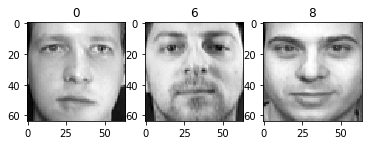

Total dataset size:
n_samples: 80
n_features: 4096
n_classes: 8


In [18]:
faces_att = get_faces("ATT")
plot_faces(faces_att)
get_data_statistics(faces_att)

## PCA
Principal Component Analysis represents a statistical approach that is well known for dimensionality reduction.
    The idea behind PCA, is to extract the relevant information from a face image, encode it as efficiently as possible and compare one query face encoding with a database of faces similarly encoded. Mathematically speaking, we wish to find the eigenvectors of the covariance matrix of the set of images. By displaying these eigenvectors, we get a ghostly representation of a face, also called eigenface. The "best" eigenfaces account for the most variance within the set of face images. 


Number of components 30
Explained variance [0.28043532 0.16058394 0.07768647 0.06058205 0.04789809 0.04211448
 0.03351866 0.02446912 0.01939861 0.01698533 0.01610395 0.01283193
 0.01250837 0.01154065 0.01086788 0.00911314 0.00829955 0.00767317
 0.00729964 0.00687529 0.00651936 0.00591334 0.005571   0.00544797
 0.00522833 0.00478068 0.00467713 0.00451837 0.00419099 0.00407127]
--- Choosed technique: PCA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


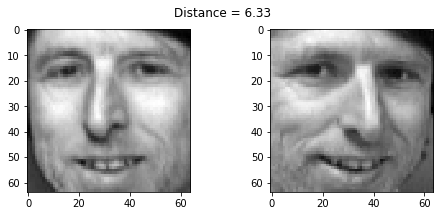

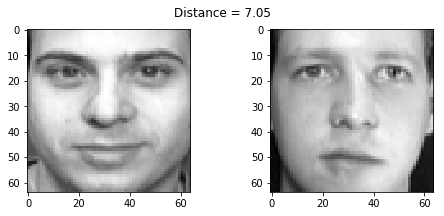

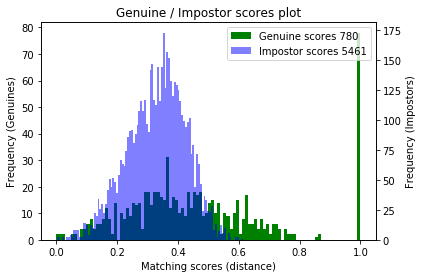

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.7268
F1 score with threshold = 0.4, is = 0.3269
Accuracy with threshold = 0.5, is = 0.8976
F1 score with threshold = 0.5, is = 0.4679
Accuracy with threshold = 0.6, is = 0.9034
F1 score with threshold = 0.6, is = 0.3712
Accuracy with threshold = 0.7, is = 0.8925
F1 score with threshold = 0.7, is = 0.2452
Accuracy with threshold = 0.8, is = 0.888
F1 score with threshold = 0.8, is = 0.1882
Optimal threshold = 0.5
6. Plotting F1 and accuracy scores 


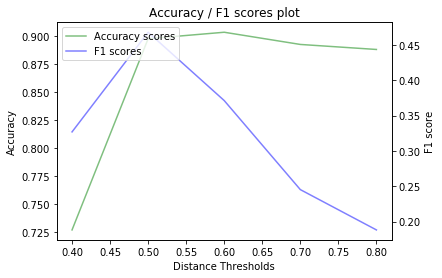

--- The most optimal threshold is: 0.5
Accuracy with threshold = 0.5, is = 0.8976
F1 score with threshold = 0.5, is = 0.4679
7. Averaged precision score is: 0.9
[0.46923077 0.63974359 0.77179487 0.86025641 0.89615385]
[0.24519318806079474, 0.025636330342428126, 0.00018311664530305805, 0.0, 0.0]
Equal Error Rate is: 0.24519318806079474
8. Plotting ROC curve (TPR vs FPR)


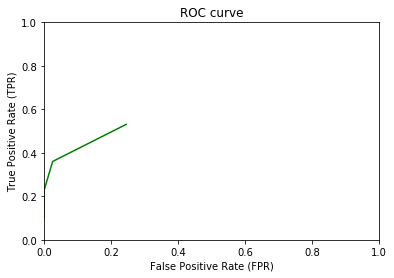

9. AUC score for thresholded distances is 0.105


In [19]:
embedded_att_pca = perform_method("PCA", faces_att)
perform_all_steps("PCA", faces_att, embedded_att_pca)

## LDA
The idea behind LDA is to find linear transformations that will maximize the discriminatory information in data.
Linear Discriminant Analysis is enhancement of Principal Component Analysis, since PCA does not use the concept of classes and LDA does. The difference between these two approaches is that PCA tries to maximize the variance of the dataset, whereas LDA maximizes the class - separation. There is research work proving that LDA outpreforms PCA when it comes to many different tasks, including face recognition.The results obtained in the example below, show the same. By observing the genuine - impostor distribution, it can be concluded that there is better sepparation and the intersect is very small compared to the one obtained by PCA. Moreover, the accuracy is 0.98 and the F1 score is 0.94, which adds to the good performance of LDA. 

Number of components 30


/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


--- Choosed technique: LDA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


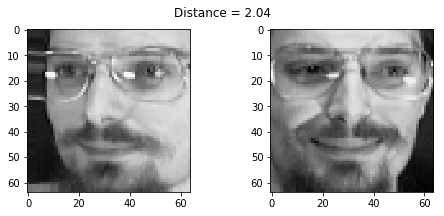

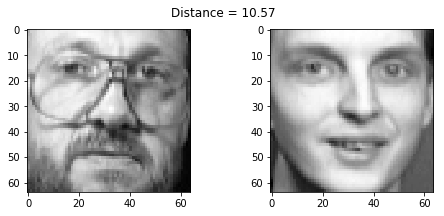

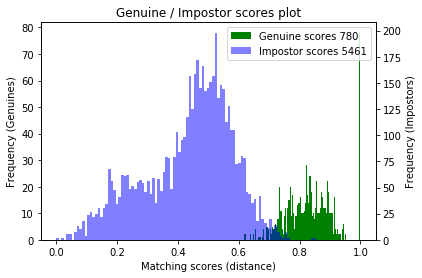

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.4156
F1 score with threshold = 0.4, is = 0.2996
Accuracy with threshold = 0.5, is = 0.6616
F1 score with threshold = 0.5, is = 0.4248
Accuracy with threshold = 0.6, is = 0.9122
F1 score with threshold = 0.6, is = 0.74
Accuracy with threshold = 0.7, is = 0.9846
F1 score with threshold = 0.7, is = 0.9401
Accuracy with threshold = 0.8, is = 0.9579
F1 score with threshold = 0.8, is = 0.7985
Optimal threshold = 0.7
6. Plotting F1 and accuracy scores 


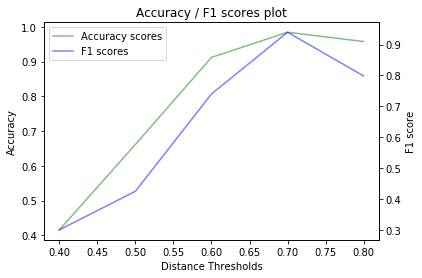

--- The most optimal threshold is: 0.7
Accuracy with threshold = 0.7, is = 0.9846
F1 score with threshold = 0.7, is = 0.9401
7. Averaged precision score is: 0.98
[0.         0.         0.         0.03333333 0.33205128]
[0.6678264054202527, 0.3867423548800586, 0.10034792162607581, 0.012818165171214063, 0.0007324665812122322]
Equal Error Rate is: 0.0
8. Plotting ROC curve (TPR vs FPR)


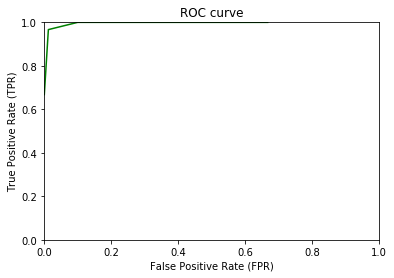

9. AUC score for thresholded distances is 0.663


In [20]:
embedded_att_lda = perform_method("LDA", faces_att)
perform_all_steps("LDA", faces_att, embedded_att_lda)

## LBP
Local Binary Patterns are described as texture descriptors, which label the pixels of the image by thresholding the neighborhood of each pixel and set the result as a binary number. This makes LBP quite different approach compared to PCA and LDA. The genuine - impostor plot shows that LBP performs better compared to PCA, but it seems that LDA still shows a bit better results.

--- Choosed technique: LBP
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


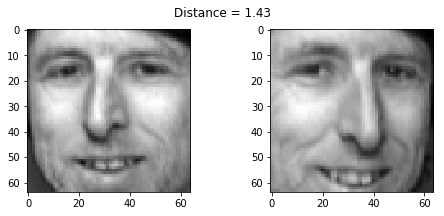

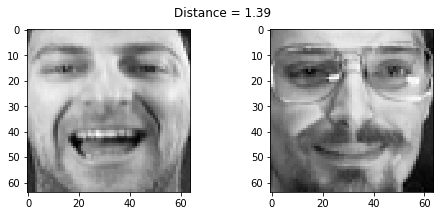

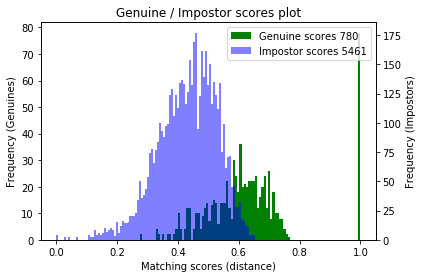

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.4246
F1 score with threshold = 0.4, is = 0.2974
Accuracy with threshold = 0.5, is = 0.7488
F1 score with threshold = 0.5, is = 0.4559
Accuracy with threshold = 0.6, is = 0.9314
F1 score with threshold = 0.6, is = 0.6796
Accuracy with threshold = 0.7, is = 0.9005
F1 score with threshold = 0.7, is = 0.3387
Accuracy with threshold = 0.8, is = 0.8875
F1 score with threshold = 0.8, is = 0.1818
Optimal threshold = 0.6
6. Plotting F1 and accuracy scores 


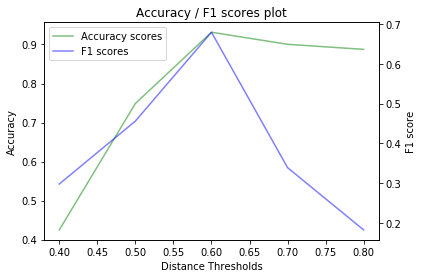

--- The most optimal threshold is: 0.6
Accuracy with threshold = 0.6, is = 0.9314
F1 score with threshold = 0.6, is = 0.6796
7. Averaged precision score is: 0.93
[0.02564103 0.15769231 0.41794872 0.79615385 0.9       ]
[0.6539095403772203, 0.2646035524629189, 0.01867789782091192, 0.0, 0.0]
Equal Error Rate is: 0.01867789782091192
8. Plotting ROC curve (TPR vs FPR)


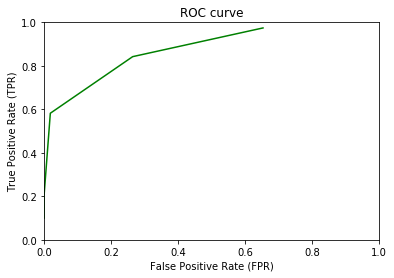

9. AUC score for thresholded distances is 0.536


In [21]:
embedded_att_lbp = perform_method("LBP", faces_att)
perform_all_steps("LBP", faces_att, embedded_att_lbp)

### Labeled Faces of the Wild

We repeat the above steps with the three different approaches, for the LFW dataset.

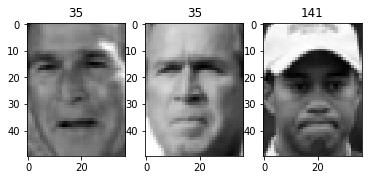

Total dataset size:
n_samples: 756
n_features: 1850
n_classes: 10


In [22]:
faces_lfw = get_faces("LFW")
plot_faces(faces_lfw)
get_data_statistics(faces_lfw)

Number of components 30
Explained variance [0.24199429 0.16072679 0.07156521 0.05810875 0.03158488 0.02901821
 0.02243957 0.02119108 0.0185903  0.01695668 0.01526446 0.01363839
 0.01273277 0.01027253 0.00895132 0.00872525 0.00824663 0.00759438
 0.0070332  0.00616261 0.00577295 0.00556871 0.00525597 0.00510014
 0.00492226 0.00483979 0.00462901 0.0044132  0.00420123 0.00400491]
--- Choosed technique: PCA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


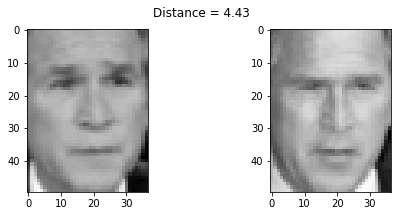

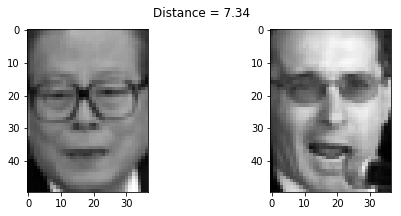

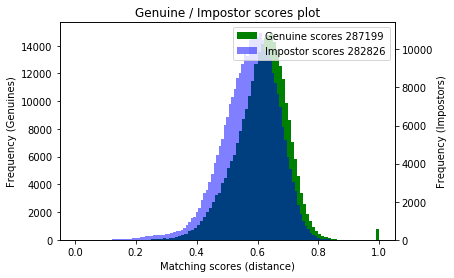

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.5157
F1 score with threshold = 0.4, is = 0.6723
Accuracy with threshold = 0.5, is = 0.546
F1 score with threshold = 0.5, is = 0.6652
Accuracy with threshold = 0.6, is = 0.5878
F1 score with threshold = 0.6, is = 0.595
Accuracy with threshold = 0.7, is = 0.5319
F1 score with threshold = 0.7, is = 0.2248
Accuracy with threshold = 0.8, is = 0.4991
F1 score with threshold = 0.8, is = 0.013
Optimal threshold = 0.4
6. Plotting F1 and accuracy scores 


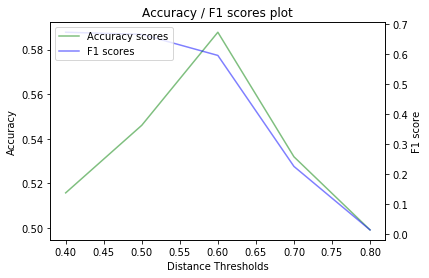

--- The most optimal threshold is: 0.4
Accuracy with threshold = 0.4, is = 0.5157
F1 score with threshold = 0.4, is = 0.6723
7. Averaged precision score is: 0.52
[0.01399378 0.1049551  0.39907521 0.86530594 0.99346098]
[0.9618564064124232, 0.8083945606132392, 0.4255832207788534, 0.06474298685410818, 0.000742505993084087]
Equal Error Rate is: 0.000742505993084087
8. Plotting ROC curve (TPR vs FPR)


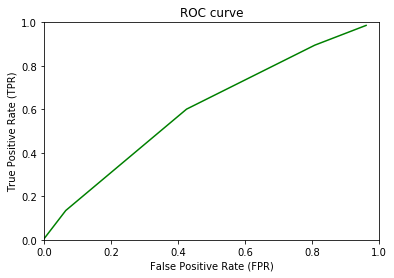

9. AUC score for thresholded distances is 0.568


In [23]:
embedded_lfw_pca = perform_method("PCA", faces_lfw)
perform_all_steps("PCA", faces_lfw, embedded_lfw_pca)

Number of components 30


/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


--- Choosed technique: LDA
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


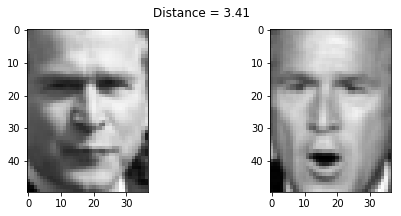

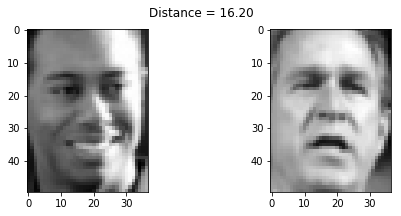

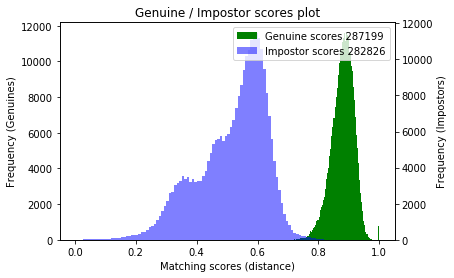

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.5899
F1 score with threshold = 0.4, is = 0.7107
Accuracy with threshold = 0.5, is = 0.6881
F1 score with threshold = 0.5, is = 0.7636
Accuracy with threshold = 0.6, is = 0.8737
F1 score with threshold = 0.6, is = 0.8886
Accuracy with threshold = 0.7, is = 0.9938
F1 score with threshold = 0.7, is = 0.9939
Accuracy with threshold = 0.8, is = 0.987
F1 score with threshold = 0.8, is = 0.9869
Optimal threshold = 0.7
6. Plotting F1 and accuracy scores 


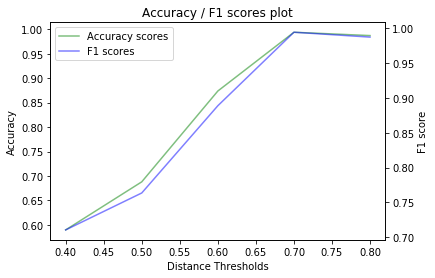

--- The most optimal threshold is: 0.7
Accuracy with threshold = 0.7, is = 0.9938
F1 score with threshold = 0.7, is = 0.9939
7. Averaged precision score is: 0.99
[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.17828753e-05
 2.55397825e-02]
[0.826614243386393, 0.628587895030867, 0.2545876263144124, 0.012498850883582132, 0.00034650279677257397]
Equal Error Rate is: 4.178287528855407e-05
8. Plotting ROC curve (TPR vs FPR)


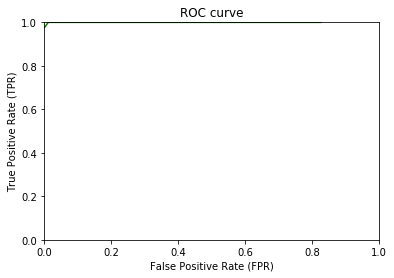

9. AUC score for thresholded distances is 0.826


In [24]:
embedded_lfw_lda = perform_method("LDA", faces_lfw)
perform_all_steps("LDA", faces_lfw, embedded_lfw_lda)

--- Choosed technique: LBP
1. Calculating feature descriptors
2. Calculating pair-wise matching scores (i.e. distances between pairs)
3. Generating genuine - impostor pairs and plotting the pairs with their matching score
4. Generating genuine - impostor distribution


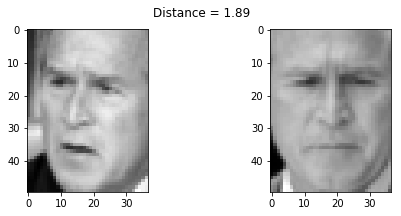

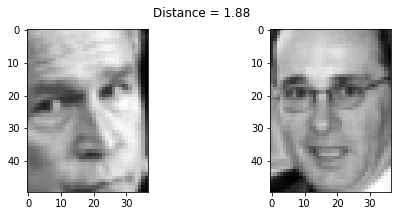

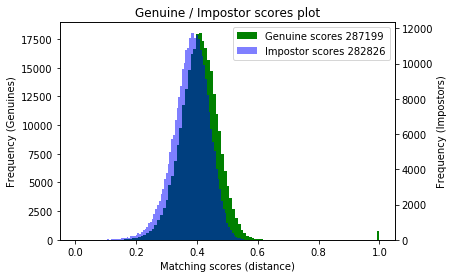

5. Computing F1 and accuracy scores for a range of thresholds
Accuracy with threshold = 0.4, is = 0.5825
F1 score with threshold = 0.4, is = 0.5738
Accuracy with threshold = 0.5, is = 0.5196
F1 score with threshold = 0.5, is = 0.1068
Accuracy with threshold = 0.6, is = 0.4978
F1 score with threshold = 0.6, is = 0.0063
Accuracy with threshold = 0.7, is = 0.4975
F1 score with threshold = 0.7, is = 0.0053
Accuracy with threshold = 0.8, is = 0.4975
F1 score with threshold = 0.8, is = 0.0052
Optimal threshold = 0.4
6. Plotting F1 and accuracy scores 


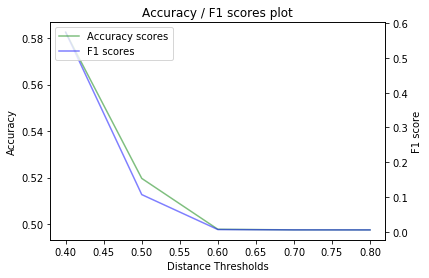

--- The most optimal threshold is: 0.4
Accuracy with threshold = 0.4, is = 0.5825
F1 score with threshold = 0.4, is = 0.5738
7. Averaged precision score is: 0.58
[0.44224736 0.94299075 0.99683843 0.99733286 0.99737464]
[0.3923437024884558, 0.010571871044387716, 0.0, 0.0, 0.0]
Equal Error Rate is: 0.3923437024884558
8. Plotting ROC curve (TPR vs FPR)


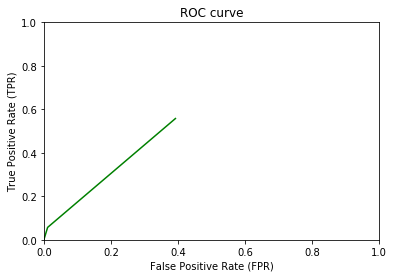

9. AUC score for thresholded distances is 0.118


In [25]:
embedded_lfw_lbp = perform_method("LBP", faces_lfw)
perform_all_steps("LBP", faces_lfw, embedded_lfw_lbp)

### Conclusion

For the two datasets, LDA show best results. Also, LBP shows good performance, very close to LDA. At last, PCA is worse compared to LDA and LBP, as it was also in the previous section.

### Result
All three approaches show good performance: with LDA we obtain best results, followed by LBP, and then PCA.